In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mt
from matplotlib.figure import Figure
from IPython.display import HTML
from abc import ABC, abstractmethod
from scipy import stats

In [2]:
# Model parameters
LINE_MODEL_STD_DEV = 0.005
LINE_MODEL_WIDTH = 0.015

# Physical parameters
SENSORS_ARRAY_LENGTH = 0.12  # 12 cm
NUMBER_OF_SENSORS = 10

# Plotting configuration
NUMBER_OF_POINTS = 1000
ANIMATION_FRAMES = 50
ANIMATION_DURATION_MS = 2500

In [3]:
class LineModel(ABC):
    def __init__(self):
        pass

    @abstractmethod
    def get_reflectance(self, position: float) -> float:
        pass


class GaussianLineModel(LineModel):
    def __init__(self, std_dev: float):
        self._std_dev = std_dev

    def get_reflectance(self, position: float) -> float:
        return np.exp((-1 / 2) * (position / self._std_dev) ** 2)


class GaussianWithWidthLineModel(LineModel):
    def __init__(self, std_dev: float, line_width: float):
        self._std_dev = std_dev
        self._line_width = line_width

    def get_reflectance(self, position: float) -> float:
        if abs(position) > self._line_width / 2:
            return np.exp(
                (-1 / 2) * ((abs(position) - self._line_width / 2) / self._std_dev) ** 2
            )

        return 1


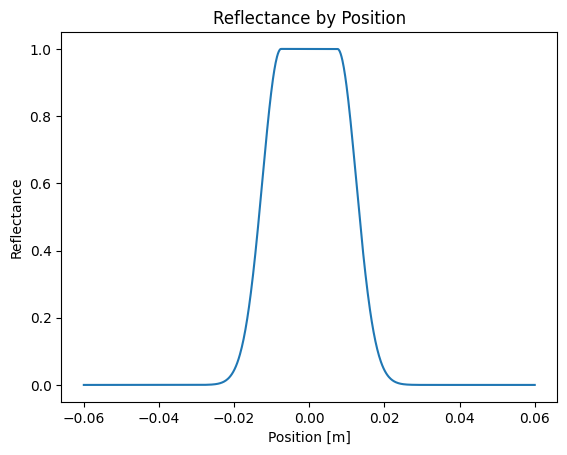

In [4]:
# line_model = GaussianLineModel(LINE_MODEL_STD_DEV)
line_model = GaussianWithWidthLineModel(LINE_MODEL_STD_DEV, LINE_MODEL_WIDTH)

positions = np.linspace(
    -SENSORS_ARRAY_LENGTH / 2, SENSORS_ARRAY_LENGTH / 2, NUMBER_OF_POINTS
)
reflectances = [line_model.get_reflectance(position) for position in positions]
fig, ax = plt.subplots()
ax.plot(positions, reflectances)
ax.set_xlabel("Position [m]")
ax.set_ylabel("Reflectance")
ax.set_title("Reflectance by Position")

plt.show()

In [5]:
class SensorsArrayModel:
    def __init__(self, sensors_positions: np.ndarray):
        self._sensors_positions = sensors_positions

    @property
    def sensors_positions(self) -> np.ndarray:
        return self._sensors_positions

    def get_readings(
        self, line_model: LineModel, line_position: float = 0.0
    ) -> np.ndarray:
        return np.array(
            [
                line_model.get_reflectance(position - line_position)
                for position in self._sensors_positions
            ]
        )


class EvenlySpacedSensorsArrayModel(SensorsArrayModel):
    def __init__(self, num_sensors: int, length: float):
        sensors_positions = np.linspace(-length / 2, length / 2, num_sensors)
        super().__init__(sensors_positions)

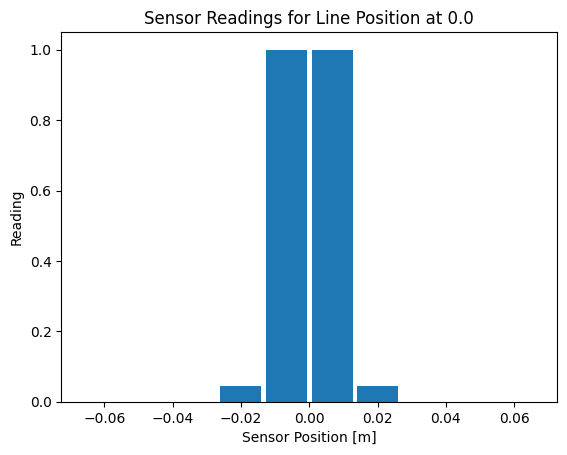

In [6]:
sensors_array_model = EvenlySpacedSensorsArrayModel(
    NUMBER_OF_SENSORS, SENSORS_ARRAY_LENGTH
)

line_position = 0.0
readings = sensors_array_model.get_readings(line_model, line_position=line_position)
width = np.min(np.diff(sensors_array_model.sensors_positions)) * 0.9

fig, ax = plt.subplots()
ax.bar(sensors_array_model.sensors_positions, readings, width=width)
ax.set_xlabel("Sensor Position [m]")
ax.set_ylabel("Reading")
ax.set_title(f"Sensor Readings for Line Position at {line_position}")

plt.show()

In [7]:
import matplotlib.animation as animation


def animate_sensor_reading(
    line_model: LineModel,
    sensors_model: SensorsArrayModel,
    length: float,
    frames: int,
    duration: int,
) -> animation.FuncAnimation:
    fig, ax = plt.subplots()
    ax.set_title("Sensor Readings for Line Position")
    ax.set_xlabel("Sensor Position [m]")
    ax.set_ylabel("Reading")

    line_positions = np.linspace(-length / 2, length / 2, frames)

    readings = sensors_model.get_readings(line_model, line_position=line_positions[0])
    bar_cont = ax.bar(
        sensors_model.sensors_positions, readings, width=width, label="Reading"
    )
    vertical_line = ax.axvline(line_positions[0], color="r", label="Line Position")
    legend = ax.legend(loc="upper right")

    def animate(i):
        readings = sensors_model.get_readings(
            line_model, line_position=line_positions[i]
        )
        for rect, y in zip(bar_cont, readings):
            rect.set_height(y)
        vertical_line.set_xdata([line_positions[i], line_positions[i]])
        return bar_cont, vertical_line, legend

    return animation.FuncAnimation(
        fig,
        animate,
        repeat=True,
        frames=frames,
        interval=duration / frames,
    )


ani = animate_sensor_reading(
    line_model,
    sensors_array_model,
    SENSORS_ARRAY_LENGTH,
    ANIMATION_FRAMES,
    ANIMATION_DURATION_MS,
)

display(HTML(ani.to_jshtml(default_mode="reflect")))
plt.close()

In [8]:
class NormalizationMethod(ABC):
    @abstractmethod
    def name(self) -> str:
        pass

    @abstractmethod
    def __call__(self, array: np.ndarray) -> np.ndarray:
        pass


class NoNormalization(NormalizationMethod):
    def name(self) -> str:
        return "No Normalization"

    def __call__(self, array: np.ndarray) -> np.ndarray:
        return array


class L1Norm(NormalizationMethod):
    def name(self) -> str:
        return "L1 Norm"

    def __call__(self, array: np.ndarray) -> np.ndarray:
        return array / np.sum(array)


class L2Norm(NormalizationMethod):
    def name(self) -> str:
        return "L2 Norm"

    def __call__(self, array: np.ndarray) -> np.ndarray:
        return array / np.linalg.norm(array)


class Softmax(NormalizationMethod):
    def name(self) -> str:
        return "Softmax"

    def __call__(self, array: np.ndarray) -> np.ndarray:
        return np.exp(array) / np.sum(np.exp(array))

In [9]:
def estimate_line_position(
    readings: np.ndarray,
    sensors_positions: np.ndarray,
    /,
    normalization: NormalizationMethod | None = None,
    weight: float = 1,
    bias: float = 0,
) -> float:
    if normalization is not None:
        values = normalization(readings)
    else:
        values = readings.copy()

    return np.sum(values * sensors_positions) * weight + bias

In [10]:
def plot_estimation(
    sensors_array_model: SensorsArrayModel,
    line_model: LineModel,
    normalization: NormalizationMethod,
    /,
    derive_parameters: bool = False,
    length: float = SENSORS_ARRAY_LENGTH,
    values: int = NUMBER_OF_POINTS,
) -> Figure:
    positions = np.linspace(-length / 2, length / 2, values)
    readings = [
        sensors_array_model.get_readings(line_model, line_position=position)
        for position in positions
    ]
    estimated_positions = [
        estimate_line_position(
            readings, sensors_array_model.sensors_positions, normalization=normalization
        )
        for readings in readings
    ]

    if derive_parameters:
        slope, intercept, _r_value, _p_value, _std_err = stats.linregress(
            positions, estimated_positions
        )
        weigth = 1 / slope
        bias = -intercept
        print(f"Derived parameters: weight={weigth:.3}, bias={bias:.3}")

        estimated_positions = [
            estimate_line_position(
                readings,
                sensors_array_model.sensors_positions,
                normalization=normalization,
                weight=weigth,
                bias=bias,
            )
            for readings in readings
        ]

    fig, ax = plt.subplots()

    ax.plot(positions, positions, linewidth=0.8, color="C1", linestyle="--", label="True Position")
    ax.plot(positions, estimated_positions, color="C0", label=normalization.name())

    trans = mt.blended_transform_factory(ax.transData, ax.transAxes)
    ax.vlines(
        sensors_array_model.sensors_positions,
        ymin=0,
        ymax=1,
        linewidth=0.5,
        color="C2",
        linestyle="--",
        transform=trans,
        label="Sensor Position",
    )

    ax.set_xlabel("True Position [m]")
    ax.set_ylabel("Estimated Position [m]")
    ax.set_title(f"Estimated Line Position - {normalization.name()}")
    ax.legend()

    return fig


Derived parameters: weight=0.508, bias=1.41e-17


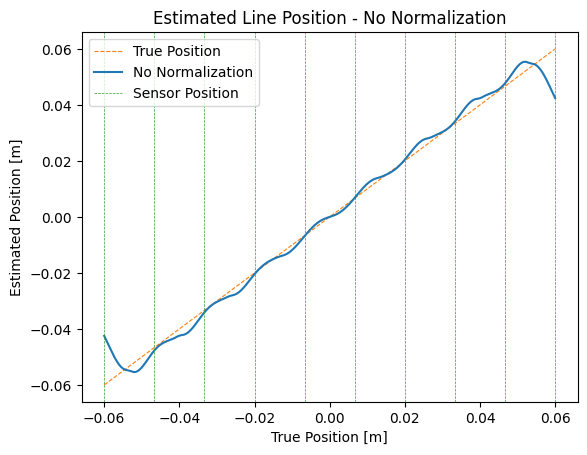

In [11]:
plot_estimation(
    sensors_array_model, line_model, NoNormalization(), derive_parameters=True
)
plt.show()

Derived parameters: weight=1.01, bias=3.5e-18


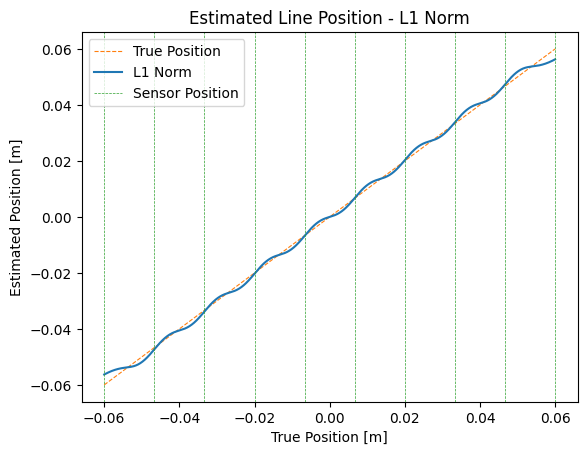

In [12]:
plot_estimation(sensors_array_model, line_model, L1Norm(), derive_parameters=True)
plt.show()

Derived parameters: weight=0.674, bias=5.27e-18


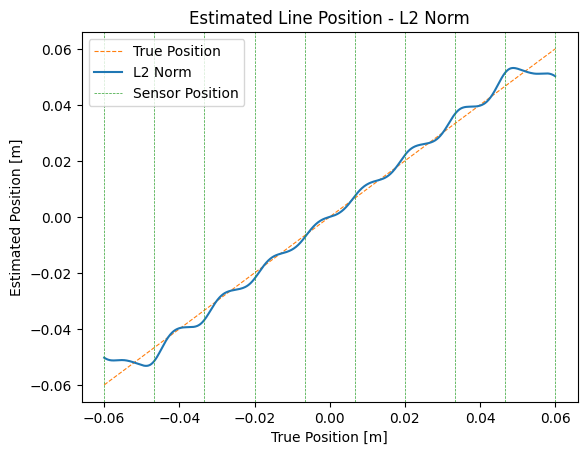

In [13]:
plot_estimation(sensors_array_model, line_model, L2Norm(), derive_parameters=True)
plt.show()

Derived parameters: weight=4.14, bias=3.08e-18


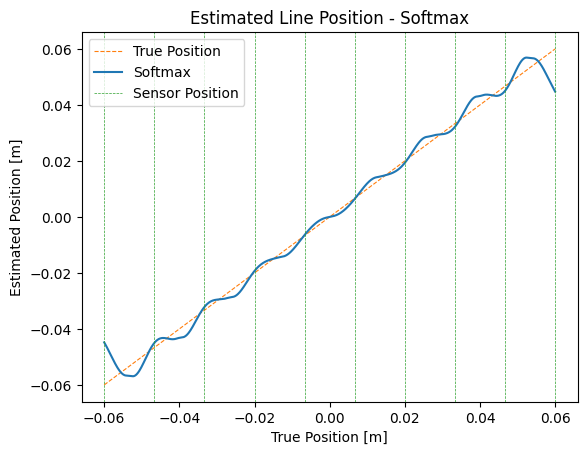

In [14]:
plot_estimation(sensors_array_model, line_model, Softmax(), derive_parameters=True)
plt.show()